In [1]:
from credit_card_churn_clf.data.data_funcs import read_credit_card_churn_split
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, label_binarize
import category_encoders as ce
import altair as alt
import numpy as np
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
alt.data_transformers.enable("json")
alt.renderers.enable("mimetype")

RendererRegistry.enable('mimetype')

In [3]:
X_train, y_train = read_credit_card_churn_split(
    "../data/splits/credit_card_churn_train_test.pkl", 
    train_or_test="train", 
    split_y=True
)

In [4]:
X_train.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
9066,54,F,1,Unknown,Single,Unknown,Blue,36,1,3,3,3723.0,1728,0.595,8554,99,0.678,0.464
5814,58,F,4,High School,Married,Unknown,Blue,48,1,4,3,5396.0,1803,0.493,2107,39,0.393,0.334
792,45,F,4,Unknown,Single,Less than $40K,Gold,36,6,1,3,15987.0,1648,0.732,1436,36,1.250,0.103
1791,34,F,2,Graduate,Single,Less than $40K,Blue,36,4,3,4,3625.0,2517,1.158,2616,46,1.300,0.694
5011,49,F,2,High School,Married,$40K - $60K,Blue,39,5,3,4,2720.0,1926,0.602,3806,61,0.794,0.708


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8101 entries, 9066 to 7270
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              8101 non-null   int64  
 1   Gender                    8101 non-null   object 
 2   Dependent_count           8101 non-null   int64  
 3   Education_Level           8101 non-null   object 
 4   Marital_Status            8101 non-null   object 
 5   Income_Category           8101 non-null   object 
 6   Card_Category             8101 non-null   object 
 7   Months_on_book            8101 non-null   int64  
 8   Total_Relationship_Count  8101 non-null   int64  
 9   Months_Inactive_12_mon    8101 non-null   int64  
 10  Contacts_Count_12_mon     8101 non-null   int64  
 11  Credit_Limit              8101 non-null   float64
 12  Total_Revolving_Bal       8101 non-null   int64  
 13  Total_Amt_Chng_Q4_Q1      8101 non-null   float64
 14  Total

In [6]:
ord_map = [
    {
        "col": "Education_Level",
        "mapping": {
            "Unknown": -1,
            "Uneducated": 0,
            "High School": 1,
            "College": 2,
            "Graduate": 3,
            "Doctorate": 3,
            "Post-Graduate": 3
        }
    },
    {
        "col": "Income_Category",
        "mapping": {
            "Unknown": -1,
            "Less than $40K": 0,
            "$40K - $60K": 1,
            "$60K - $80K": 2,
            "$80K - $120K": 3,
            "$120K +": 4
        }
    }
]

col_transf = ColumnTransformer([
    ("gender_marital_oh", OneHotEncoder(), ["Gender", "Marital_Status"]),
    ("card_type_oh", OneHotEncoder(min_frequency=0.1), ["Card_Category"]),
    ("edu_income_ord", ce.OrdinalEncoder(mapping=ord_map), ["Education_Level", "Income_Category"]),
    ("log_trans", FunctionTransformer(func=np.log1p), ["Credit_Limit", "Total_Revolving_Bal", "Total_Trans_Amt", "Avg_Utilization_Ratio"]),
    ("std_scaler", StandardScaler(), ["Customer_Age", "Months_on_book", "Total_Amt_Chng_Q4_Q1", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1"]),
],
    remainder="passthrough")

In [7]:
def get_model(model: str, random_state: int = 42):
    models_dict = {
        "LogisticRegression": {
            "estimator": LogisticRegression(random_state=random_state, solver="saga", class_weight="balanced"),
            "params_grid": {
                "clf__penalty": ["l1", "l2", "elasticnet", "none"],
                "clf__C": stats.uniform(loc=0, scale=10),
                "clf__l1_ratio": stats.uniform(loc=0, scale=1)
            }
        },
        "DecisionTreeClassifier": {
            "estimator": DecisionTreeClassifier(random_state=random_state),
            "params_grid": {
                "clf__min_samples_split": stats.beta(a=3, b=70),
                "clf__min_samples_leaf": stats.beta(a=3, b=250),
                "clf__class_weight": [None, "balanced"]
            }
        },
        "RandomForestClassifier": {
            "estimator": RandomForestClassifier(random_state=random_state),
            "params_grid": {
                "clf__n_estimators": [100, 150, 200],
                "clf__min_samples_split": stats.beta(a=2, b=70),
                "clf__min_samples_leaf": stats.beta(a=2, b=250),
                "clf__max_depth": [None, 5, 10, 15, 20],
                "clf__max_features": stats.beta(a=200, b=80),
                "clf__class_weight": [None, "balanced", "balanced_subsample"],
            }
        },
        "GradientBoostingClassifier": {
            "estimator": GradientBoostingClassifier(random_state=random_state),
            "params_grid": {
                "clf__loss": ["log_loss", "exponential"],
                "clf__learning_rate": stats.uniform(loc=0, scale=1),
                "clf__subsample": stats.uniform(loc=0, scale=1),
                "clf__n_estimators": [50, 100, 150],
                "clf__min_samples_split": stats.beta(a=3, b=70),
                "clf__min_samples_leaf": stats.beta(a=3, b=250),
                "clf__max_depth": [None, 5, 10],
                "clf__max_features": stats.uniform(loc=0, scale=1),
            }
        }
    }
    return models_dict[model]

## Regressão Logistica

In [8]:
lr_model = get_model("LogisticRegression")

lr_pipe = Pipeline([
    ("col_transf", col_transf),
    ("clf", lr_model["estimator"])
])

lr_cv = RandomizedSearchCV(
    lr_pipe,
    lr_model["params_grid"],
    n_iter=50,
    scoring="roc_auc",
    n_jobs=-1,
    cv=5
)

lr_cv.fit(X_train, y_train)

C:\Users\silas\Projetos\credit-card-churn-clf\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\silas\Projetos\credit-card-churn-clf\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\silas\Projetos\credit-card-churn-clf\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('col_transf',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('gender_marital_oh',
                                                                               OneHotEncoder(),
                                                                               ['Gender',
                                                                                'Marital_Status']),
                                                                              ('card_type_oh',
                                                                               OneHotEncoder(min_frequency=0.1),
                                                                               ['Card_Category']),
                                                                              ('edu_income_ord',
                                                                               OrdinalEncoder(mapping=[{'col': 'Education_Level',
                                                                                                        'mapping': {'College': 2,
                                                                                                                    'Docto...
                                              LogisticRegression(class_weight='balanced',
                                                                 random_state=42,
                                                                 solver='saga'))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'clf__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000258A6BA8220>,
                                        'clf__l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000258A6BAB370>,
                                        'clf__penalty': ['l1', 'l2',
                                                         'elasticnet',
                                                         'none']},
                   scoring='roc_auc')

In [9]:
print("Best Params: ", lr_cv.best_params_)
print("Best Score: ", lr_cv.best_score_)

Best Params:  {'clf__C': 8.704859448942559, 'clf__l1_ratio': 0.7090422057260267, 'clf__penalty': 'none'}
Best Score:  0.937262933828932


## Decision Tree

In [10]:
dt_model = get_model("DecisionTreeClassifier")

dt_pipe = Pipeline([
    ("col_transf", col_transf),
    ("clf", dt_model["estimator"])
])

dt_cv = RandomizedSearchCV(
    dt_pipe,
    dt_model["params_grid"],
    n_iter=50,
    scoring="roc_auc",
    n_jobs=-1,
    cv=5
)

dt_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('col_transf',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('gender_marital_oh',
                                                                               OneHotEncoder(),
                                                                               ['Gender',
                                                                                'Marital_Status']),
                                                                              ('card_type_oh',
                                                                               OneHotEncoder(min_frequency=0.1),
                                                                               ['Card_Category']),
                                                                              ('edu_income_ord',
                                                                               OrdinalEncoder(mapping=[{'col': 'Education_Level',
                                                                                                        'mapping': {'College': 2,
                                                                                                                    'Docto...
                                              DecisionTreeClassifier(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'clf__class_weight': [None, 'balanced'],
                                        'clf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000258A7D13DF0>,
                                        'clf__min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000258A7D25460>},
                   scoring='roc_auc')

In [11]:
results_dt = pd.DataFrame(dt_cv.cv_results_).sort_values("rank_test_score")
print("Best Params: ", dt_cv.best_params_)
print("Best Score: ", dt_cv.best_score_)

Best Params:  {'clf__class_weight': None, 'clf__min_samples_leaf': 0.005254160490109643, 'clf__min_samples_split': 0.014971632706636883}
Best Score:  0.961122750647481


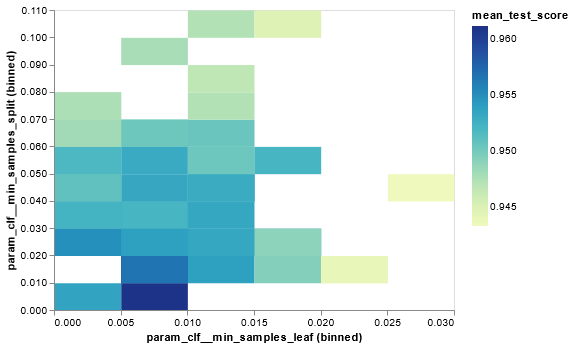

In [12]:
alt.Chart(results_dt).mark_rect().encode(
    x=alt.X("param_clf__min_samples_leaf", bin=alt.Bin(maxbins=10)),
    y=alt.Y("param_clf__min_samples_split", bin=alt.Bin(maxbins=10)),
    color="mean_test_score",
    tooltip="mean_test_score"
)

## Random Forests

In [13]:
rf_model = get_model("RandomForestClassifier")

rf_pipe = Pipeline([
    ("col_transf", col_transf),
    ("clf", rf_model["estimator"])
])

rf_cv = RandomizedSearchCV(
    rf_pipe,
    rf_model["params_grid"],
    n_iter=50,
    scoring="roc_auc",
    n_jobs=-1,
    cv=5
)

rf_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('col_transf',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('gender_marital_oh',
                                                                               OneHotEncoder(),
                                                                               ['Gender',
                                                                                'Marital_Status']),
                                                                              ('card_type_oh',
                                                                               OneHotEncoder(min_frequency=0.1),
                                                                               ['Card_Category']),
                                                                              ('edu_income_ord',
                                                                               OrdinalEncoder(mapping=[{'col': 'Education_Level',
                                                                                                        'mapping': {'College': 2,
                                                                                                                    'Docto...
                                        'clf__max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000258A6B9CBE0>,
                                        'clf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000258A7CF9910>,
                                        'clf__min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000258A7D13400>,
                                        'clf__n_estimators': [100, 150, 200]},
                   scoring='roc_auc')

In [14]:
results_rf = pd.DataFrame(rf_cv.cv_results_).sort_values("rank_test_score")
print("Best Params: ", rf_cv.best_params_)
print("Best Score: ", rf_cv.best_score_)

Best Params:  {'clf__class_weight': 'balanced_subsample', 'clf__max_depth': None, 'clf__max_features': 0.7538805347416688, 'clf__min_samples_leaf': 0.0014906489145686678, 'clf__min_samples_split': 0.008876025382397146, 'clf__n_estimators': 100}
Best Score:  0.9827240791472865


In [15]:
results_rf.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__class_weight,param_clf__max_depth,param_clf__max_features,param_clf__min_samples_leaf,param_clf__min_samples_split,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
37,4.224511,0.549336,0.096001,0.044611,balanced_subsample,None,0.753881,0.001491,0.008876,100,"{'clf__class_weight': 'balanced_subsample', 'c...",0.983954,0.980376,0.980294,0.981745,0.987251,0.982724,0.002622,1
19,3.322990,0.131763,0.088567,0.025368,balanced_subsample,10,0.706405,0.001773,0.013688,100,"{'clf__class_weight': 'balanced_subsample', 'c...",0.981397,0.979613,0.977786,0.979463,0.985269,0.980705,0.002552,2
24,4.013529,0.336113,0.083978,0.011632,balanced,None,0.705118,0.003013,0.012884,150,"{'clf__class_weight': 'balanced', 'clf__max_de...",0.979978,0.979183,0.978117,0.979545,0.984236,0.980212,0.002105,3
32,3.995818,0.428907,0.116130,0.026904,balanced_subsample,20,0.687255,0.000961,0.018519,100,"{'clf__class_weight': 'balanced_subsample', 'c...",0.981072,0.977941,0.976106,0.978730,0.984166,0.979603,0.002783,4
15,2.443747,0.024165,0.057730,0.002339,balanced,20,0.700339,0.003572,0.015765,100,"{'clf__class_weight': 'balanced', 'clf__max_de...",0.978093,0.977571,0.977195,0.978128,0.983173,0.978832,0.002198,5


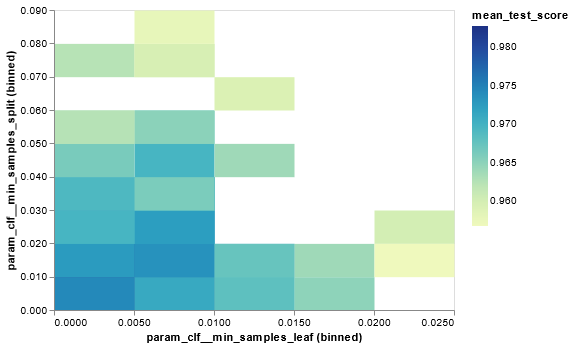

In [16]:
alt.Chart(results_rf).mark_rect().encode(
    x=alt.X("param_clf__min_samples_leaf", bin=alt.Bin(maxbins=10)),
    y=alt.Y("param_clf__min_samples_split", bin=alt.Bin(maxbins=10)),
    color="mean_test_score",
    tooltip="mean_test_score"
)

## Gradient Boosting

In [17]:
gb_model = get_model("GradientBoostingClassifier")

gb_pipe = Pipeline([
    ("col_transf", col_transf),
    ("clf", gb_model["estimator"])
])

gb_cv = RandomizedSearchCV(
    gb_pipe,
    gb_model["params_grid"],
    n_iter=50,
    scoring="roc_auc",
    n_jobs=-1,
    cv=5
)

gb_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('col_transf',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('gender_marital_oh',
                                                                               OneHotEncoder(),
                                                                               ['Gender',
                                                                                'Marital_Status']),
                                                                              ('card_type_oh',
                                                                               OneHotEncoder(min_frequency=0.1),
                                                                               ['Card_Category']),
                                                                              ('edu_income_ord',
                                                                               OrdinalEncoder(mapping=[{'col': 'Education_Level',
                                                                                                        'mapping': {'College': 2,
                                                                                                                    'Docto...
                                        'clf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000258A7C41AC0>,
                                        'clf__min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000258A7D25340>,
                                        'clf__n_estimators': [50, 100, 150],
                                        'clf__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000258A7D25220>},
                   scoring='roc_auc')

In [18]:
results_gb = pd.DataFrame(gb_cv.cv_results_).sort_values("rank_test_score")
print("Best Params: ", gb_cv.best_params_)
print("Best Score: ", gb_cv.best_score_)

Best Params:  {'clf__learning_rate': 0.08502933160982429, 'clf__loss': 'log_loss', 'clf__max_depth': None, 'clf__max_features': 0.5058014145095524, 'clf__min_samples_leaf': 0.004022231863145898, 'clf__min_samples_split': 0.04833086550684027, 'clf__n_estimators': 150, 'clf__subsample': 0.8479839094685359}
Best Score:  0.9934261377048419
